# Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# Load the data

In [2]:
# Load the data
x_train = pd.read_csv('../data-challenge/x_train_sncf.csv')
x_test = pd.read_csv('../data-challenge/x_test_sncf.csv')
y_train = pd.read_csv('../data-challenge/y_train_sncf.csv')

In [3]:
# add the index column on x_train
x_train['index'] = x_train['date'].str.cat(x_train['station'], sep='_')
x_train.head()

,date,station,job,ferie,vacances,index
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3


In [4]:
# merge x_train and y_train on index
data_train = pd.merge(x_train, y_train, on='index')
data_train = data_train[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']]
data_train['train'] = 1

data_train.head()

,date,station,index,job,ferie,vacances,y,train
0,2015-01-01,1J7,2015-01-01_1J7,1,1,1,7,1
1,2015-01-01,O2O,2015-01-01_O2O,1,1,1,0,1
2,2015-01-01,8QR,2015-01-01_8QR,1,1,1,9,1
3,2015-01-01,UMC,2015-01-01_UMC,1,1,1,9,1
4,2015-01-01,FK3,2015-01-01_FK3,1,1,1,28,1


In [5]:
# merge the above data with x_test
x_test['train'] = 0
merged_data = pd.concat([data_train, x_test], ignore_index=True).sort_values(by=['date'])
merged_data['y'] = merged_data['y'].fillna(0)

merged_data.tail()

,date,station,index,job,ferie,vacances,y,train
1307138,2023-06-30,4AH,2023-06-30_4AH,1,0,0,0.0,0
1307139,2023-06-30,8XN,2023-06-30_8XN,1,0,0,0.0,0
1307140,2023-06-30,ESA,2023-06-30_ESA,1,0,0,0.0,0
1307129,2023-06-30,X6B,2023-06-30_X6B,1,0,0,0.0,0
1306842,2023-06-30,HW6,2023-06-30_HW6,1,0,0,0.0,0


## Data exploration

### Get all the stations

In [6]:
stations = merged_data['station'].unique()
stations

array(['1J7', 'S3E', 'RDK', 'I9U', 'OM7', '09U', '0S9', 'KO0', '4WI',
       '23N', 'WVV', 'SWS', 'TFW', 'X3T', 'I8D', 'EOE', 'MBC', 'VS0',
       'EVR', 'BZL', 'DF2', 'APM', '12Q', 'L6F', 'WDP', 'ZII', 'W67',
       '4V8', '214', '2YA', 'L15', 'PRZ', '2UV', 'OF0', 'PCE', 'UAJ',
       'K75', '9RF', '2EW', '6E0', '033', 'KHT', 'P8U', 'CW1', 'AK3',
       'IJR', 'CM6', 'NZP', 'ICH', 'Q62', '19G', 'CS1', 'T2H', 'TMT',
       'DRI', 'KAX', 'BC6', '6VM', 'UCE', '0CM', 'V5L', 'BI7', 'Q5M',
       '1EB', 'IAM', 'AOW', 'YX9', '7EJ', '0WC', 'WQR', 'WQO', 'LHY',
       '193', 'PQF', 'XN6', '0YY', '1VL', '1AA', 'A1R', '9P6', '6HE',
       '700', 'SZ5', 'H2M', 'SSM', 'G1F', 'QTM', 'K6N', 'N6O', 'HZ1',
       'ZIK', '294', 'Y1C', 'BUH', 'XM1', '0GU', 'B34', 'NXN', '9MC',
       'JFA', 'AGN', 'I6E', 'W68', 'VZD', 'V6N', '5SM', 'UM6', '4RW',
       'MPO', 'MX8', 'MBB', 'FTX', 'PD6', 'T16', 'I10', 'WNT', '4EG',
       'X2X', 'HN1', 'ARC', 'T5V', 'K2M', 'V2R', 'OE1', '94K', 'C5E',
       'VTE', '2T1',

## Idea : treat each station independently, create a DataFrame with each station

In [7]:
df_per_station = {station: merged_data[merged_data['station'] == station].sort_values(by='date')[["date", "job", "ferie", "vacances", "y", "train"]] for station in stations}

In [8]:
df_per_station['O2O'].head()

,date,job,ferie,vacances,y,train
1,2015-01-01,1,1,1,0.0,1
40303,2015-01-02,1,0,1,8.0,1
80892,2015-01-03,0,0,1,0.0,1
121380,2015-01-04,0,0,1,0.0,1
161890,2015-01-05,1,0,0,27.0,1


In [9]:
print(list(df_per_station['O2O']['y']))

[0.0, 8.0, 0.0, 0.0, 27.0, 35.0, 21.0, 31.0, 27.0, 0.0, 0.0, 24.0, 22.0, 20.0, 24.0, 24.0, 0.0, 5.0, 24.0, 22.0, 27.0, 25.0, 21.0, 6.0, 0.0, 22.0, 22.0, 24.0, 22.0, 23.0, 0.0, 0.0, 27.0, 33.0, 20.0, 25.0, 23.0, 8.0, 31.0, 23.0, 20.0, 21.0, 22.0, 16.0, 0.0, 12.0, 25.0, 25.0, 15.0, 20.0, 19.0, 0.0, 6.0, 14.0, 11.0, 18.0, 16.0, 19.0, 0.0, 7.0, 24.0, 24.0, 20.0, 26.0, 20.0, 6.0, 13.0, 22.0, 19.0, 21.0, 21.0, 22.0, 0.0, 14.0, 25.0, 28.0, 15.0, 19.0, 18.0, 7.0, 5.0, 23.0, 24.0, 19.0, 20.0, 18.0, 0.0, 9.0, 23.0, 27.0, 19.0, 19.0, 17.0, 0.0, 14.0, 19.0, 22.0, 22.0, 18.0, 22.0, 5.0, 0.0, 23.0, 25.0, 22.0, 29.0, 17.0, 0.0, 5.0, 20.0, 21.0, 17.0, 21.0, 16.0, 0.0, 0.0, 22.0, 22.0, 16.0, 18.0, 0.0, 0.0, 15.0, 26.0, 27.0, 24.0, 21.0, 0.0, 6.0, 0.0, 26.0, 19.0, 15.0, 0.0, 6.0, 0.0, 6.0, 20.0, 15.0, 19.0, 23.0, 24.0, 6.0, 0.0, 5.0, 22.0, 19.0, 21.0, 20.0, 0.0, 15.0, 18.0, 20.0, 16.0, 19.0, 14.0, 0.0, 0.0, 20.0, 21.0, 16.0, 22.0, 21.0, 0.0, 37.0, 21.0, 21.0, 5.0, 17.0, 7.0, 12.0, 19.0, 14.0, 12.0, 18.0

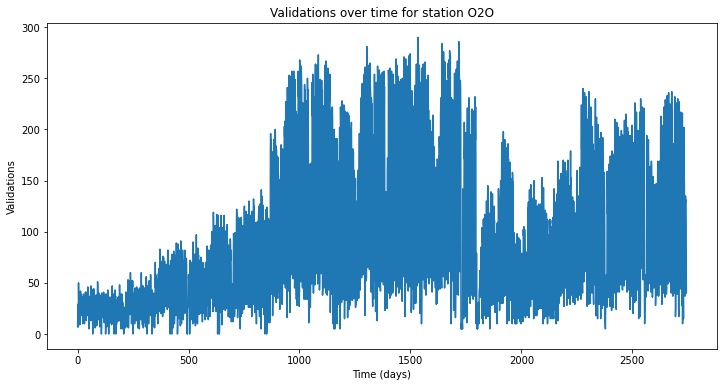

In [234]:

plt.figure(figsize=(12, 6))
plt.plot(np.array(df_per_station['1J7'][df_per_station['1J7']['train'] == 1]['y']))
plt.xlabel('Time (days)')
plt.ylabel('Validations')
plt.title('Validations over time for station O2O')
plt.show()

# Model training

In [195]:
def create_sequences(data, window_past, window_future=1):
    """
    Create sequences from the data of the form:
    x = [t-window_past, t-window_past+1, ..., t-1]
    y = [t, t+1, ..., t+window_future-1]
    """
    xs, ys = [], []
    for i in range(len(data)-window_past):
        end_input = i + window_past
        end_output = end_input + window_future
        if end_output > len(data):
            break
        x = data.iloc[i:end_input]
        y = data.iloc[end_input:end_output, data.shape[1]-1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [181]:
# count the number of 'y' values which corresponds to train = 0 for the station 'O2O'
print(len(df_per_station['O2O'][df_per_station['O2O']['train'] == 0]['y']))

173


In [182]:
# count the number of 'y' values which corresponds to train = 1 for the station 'O2O'
print(len(df_per_station['O2O'][df_per_station['O2O']['train'] == 1]['y']))

2832


In [196]:
window_past = 30
window_future = 1
#window_future = (pd.to_datetime('2023-06-30') - pd.to_datetime('2023-01-01')).days

sequences_x = []
sequences_y = []

# Example for one station : O2O

#for station in df_per_station.keys():
for station in ['O2O']:
    df = df_per_station[station][['job', 'ferie', 'vacances', 'y']]
    x, y = create_sequences(df, window_past, window_future)
    sequences_x.append(x)
    sequences_y.append(y)

len_test = len(df_per_station['O2O'][df_per_station['O2O']['train'] == 0]['y'])
sequences_x = np.concatenate(sequences_x, dtype=float)
sequences_y = np.concatenate(sequences_y, dtype=float)

sequences_x_train = sequences_x[:-len_test]
sequences_y_train = sequences_y[:-len_test]
X_test = sequences_x[-len_test:]

X_train, X_val, Y_train, Y_val = train_test_split(sequences_x_train, sequences_y_train, test_size=0.2, shuffle=False)

In [190]:
X_train[0]

array([[ 1.,  1.,  1.,  0.],
       [ 1.,  0.,  1.,  8.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0., 27.],
       [ 1.,  0.,  0., 35.],
       [ 1.,  0.,  0., 21.],
       [ 1.,  0.,  0., 31.],
       [ 1.,  0.,  0., 27.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0., 24.],
       [ 1.,  0.,  0., 22.],
       [ 1.,  0.,  0., 20.],
       [ 1.,  0.,  0., 24.],
       [ 1.,  0.,  0., 24.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5.],
       [ 1.,  0.,  0., 24.],
       [ 1.,  0.,  0., 22.],
       [ 1.,  0.,  0., 27.],
       [ 1.,  0.,  0., 25.],
       [ 1.,  0.,  0., 21.],
       [ 0.,  0.,  0.,  6.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0., 22.],
       [ 1.,  0.,  0., 22.],
       [ 1.,  0.,  0., 24.],
       [ 1.,  0.,  0., 22.],
       [ 1.,  0.,  0., 23.]])

In [198]:
X_train.shape   # (nb_sequences, sequence_length, nb_features)

(2241, 30, 4)

In [199]:
X_val.shape

(561, 30, 4)

In [200]:
Y_train.shape  # (nb_sequences, num_timesteps)

(2241, 1)

In [197]:
X_test.shape

(173, 30, 4)

In [201]:
X_test[0]

array([[ 1.,  0.,  0., 37.],
       [ 0.,  0.,  0., 20.],
       [ 0.,  0.,  0., 25.],
       [ 1.,  0.,  0., 40.],
       [ 1.,  0.,  0., 45.],
       [ 1.,  0.,  0., 42.],
       [ 1.,  0.,  0., 44.],
       [ 1.,  0.,  0., 35.],
       [ 0.,  0.,  0., 22.],
       [ 0.,  0.,  0., 32.],
       [ 1.,  0.,  0., 43.],
       [ 1.,  0.,  0., 46.],
       [ 1.,  0.,  0., 38.],
       [ 1.,  0.,  0., 44.],
       [ 1.,  0.,  0., 43.],
       [ 0.,  0.,  1., 11.],
       [ 0.,  0.,  1., 21.],
       [ 1.,  0.,  1., 33.],
       [ 1.,  0.,  1., 41.],
       [ 1.,  0.,  1., 36.],
       [ 1.,  0.,  1., 29.],
       [ 1.,  0.,  1., 28.],
       [ 0.,  0.,  1., 10.],
       [ 0.,  1.,  1., 21.],
       [ 1.,  0.,  1., 20.],
       [ 1.,  0.,  1., 20.],
       [ 1.,  0.,  1., 17.],
       [ 1.,  0.,  1., 19.],
       [ 1.,  0.,  1., 19.],
       [ 0.,  0.,  1., 15.]])

In [202]:
df_per_station['O2O'][df_per_station['O2O']['train'] == 1].tail()

,date,job,ferie,vacances,y,train
1090922,2022-12-27,1,0,1,20.0,1
1131208,2022-12-28,1,0,1,17.0,1
1168888,2022-12-29,1,0,1,19.0,1
1205840,2022-12-30,1,0,1,19.0,1
1229428,2022-12-31,0,0,1,15.0,1


In [229]:
class BasicTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size_lstm, hidden_size_fc, num_layers):
        super(BasicTimeSeriesRegression, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size_lstm, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size_lstm, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc1(output[:, -1, :])
        return output

class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm1(x)
        output, _ = self.lstm2(output)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

In [ ]:
import torch
import torch.nn as nn

class ForecastingCNN(nn.Module):
    def __init__(self):
        super(ForecastingCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 23, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x


In [204]:
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-4):
    return np.mean(np.abs((y_true+eps - y_pred+eps) / (y_true+eps))) * 100

In [230]:
window_past = 30
window_future = 1
#window_future = (pd.to_datetime('2023-06-30') - pd.to_datetime('2023-01-01')).days

# Create an empty y_test dataframe
y_test = pd.DataFrame()
# Convert 'date' column to string type
x_test['date'] = x_test['date'].astype(str)
# First column name is 'index'
y_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
# Second column name is 'y'
y_test['y'] = 0


for station in df_per_station.keys():
    print("-------------------------Station : ",station,"-------------------------")
    sequences_x = []
    sequences_y = []

    df = df_per_station[station][['job', 'ferie', 'vacances', 'y']]
    x, y = create_sequences(df, window_past, window_future)
    sequences_x.append(x)
    sequences_y.append(y)

    len_test = len(df_per_station[station][df_per_station[station]['train'] == 0]['y'])
    sequences_x = np.concatenate(sequences_x, dtype=float)
    sequences_y = np.concatenate(sequences_y, dtype=float)

    sequences_x_train = sequences_x[:-len_test]
    sequences_y_train = sequences_y[:-len_test]
    X_test = sequences_x[-len_test:]

    X_train, X_val, Y_train, Y_val = train_test_split(sequences_x_train, sequences_y_train, test_size=0.2, shuffle=False)

    model = BasicTimeSeriesRegression(input_size=4, hidden_size_lstm=100, hidden_size_fc=2, num_layers=3)

    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

    num_epochs = 100
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        optimizer.zero_grad()
        loss = criterion(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, Y_val_tensor)
            val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()} - Val Loss: {val_loss.item()}")
            print(f"MAPE: {mean_absolute_percentage_error(Y_val, val_outputs.detach().numpy())}")
        
    plt.plot(losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.legend()
    plt.show()

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    pred_list = []
    # Loop through each sample in X_test
    for i in range(len(X_test_tensor)):
        # Convert the sample to a tensor
        sample = torch.tensor(X_test_tensor[i].view(1, window_past, 4), dtype=torch.float32)
        
        # Predict the future value
        prediction = model(sample)
        if i < len(X_test_tensor)-1:
            temp = X_test_tensor[i][1:]
            temp2 = X_test_tensor[i+1][-1]
            temp2[3] = prediction
            X_test_tensor[i+1] = torch.cat((temp, temp2.unsqueeze(0)))

        pred_list.append(prediction.item())
    
    y_test.loc[y_test['index'].str.contains(station), 'y'] = pred_list

y_test.to_csv('y_test_submit_lstm_each_station.csv', index=False)

-------------------------Station :  1J7 -------------------------
Epoch 0 - Loss: 101.44116973876953 - Val Loss: 127.5323257446289
MAPE: 99.77545604391742
Epoch 10 - Loss: 98.91450500488281 - Val Loss: 124.70319366455078
MAPE: 95.89269774838223


KeyboardInterrupt: 